<a href="https://colab.research.google.com/github/afabiani/ForexEA/blob/master/GOLD_USD_Fred_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

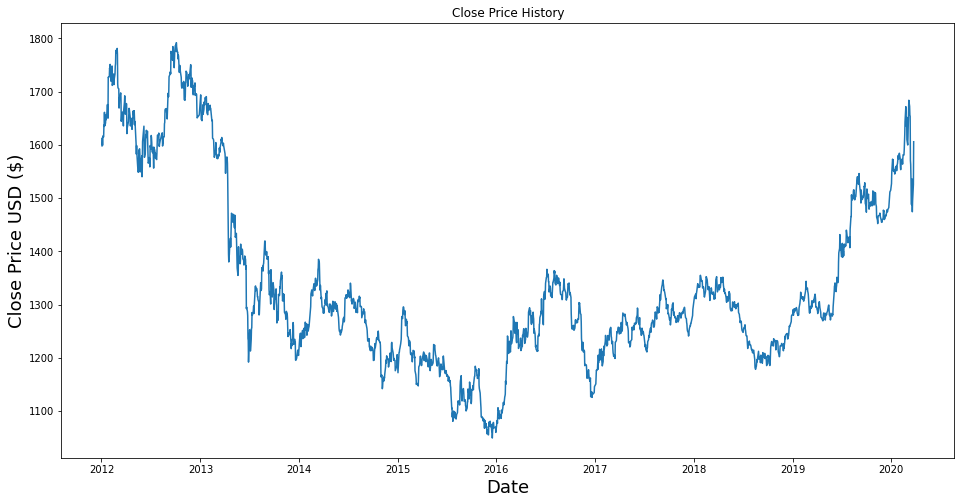

In [675]:
import os
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.layers import Dropout, Dense, Flatten, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

# Get the quotes
df = web.DataReader('GOLDPMGBD228NLBM', 'fred', '2012-01-01', '2020-03-25')
# Show the data
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df.index)
df.set_axis(df['Date'], inplace=True)

# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['GOLDPMGBD228NLBM'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [685]:
close_data = df['GOLDPMGBD228NLBM'].values
close_data = close_data.reshape((-1,1))


# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

split_percent = 0.80
split = int(split_percent*len(scaled_data))

close_train = scaled_data[:split]
close_test = scaled_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

# Split the data into x_train and y_train data sets
batch_size = 20
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=batch_size)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

# Design the model - LSTM Network
seed = 2020
np.random.seed(seed)

# Create the model using the parameterised horizon
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(60, input_dim=look_back, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model
num_epochs = 300
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/300
82/82 [==============================] - 22s 267ms/step - loss: 0.6538 - acc: 0.0012
Epoch 2/300
82/82 [==============================] - 5s 66ms/step - loss: 0.6197 - acc: 0.0012
Epoch 3/300
82/82 [==============================] - 5s 67ms/step - loss: 0.6805 - acc: 6.0978e-04
Epoch 4/300
82/82 [==============================] - 6s 67ms/step - loss: 0.6759 - acc: 6.0978e-04
Epoch 5/300
82/82 [==============================] - 5s 66ms/step - loss: 0.6686 - acc: 6.0978e-04
Epoch 6/300
82/82 [==============================] - 5s 67ms/step - loss: 0.6721 - acc: 6.0978e-04
Epoch 7/300
82/82 [==============================] - 5s 66ms/step - loss: 0.5924 - acc: 6.0978e-04
Epoch 8/300
82/82 [==============================] - 6s 67ms/step - loss: 0.5865 - acc: 0.0012
Epoch 9/300
82/82 [==============================] - 5s 67ms/step - loss: 0.5717 - acc: 0.0012
Epoch 10/300
82/82 [==============================] - 5s 66ms/step - loss: 0.5599 - acc: 0.0012
Epoch 11/300
82/82 [=======

In [686]:
# Get the models predicted price values 
predictions = model.predict_generator(test_generator)
predictions = scaler.inverse_transform(predictions)

# Plot the data
close_train_data = scaler.inverse_transform(close_train)
close_test_data = scaler.inverse_transform(close_test)
prediction_data = predictions.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train_data.reshape((-1)),
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction_data,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test_data.reshape((-1)),
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Gold/USD",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [688]:
# Forecasting
close_data_samples = scaled_data.reshape((-1))

def predict(num_predictions, model):
    prediction_list = close_data_samples[-look_back:]
    
    for _ in range(num_predictions):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    return prediction_list
    
def predict_dates(num_predictions):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_predictions+1).tolist()
    return prediction_dates

num_predictions = look_back

forecasts = predict(num_predictions, model)
forecasts = scaler.inverse_transform(forecasts.reshape(-1, 1))
forecast_dates = predict_dates(num_predictions)

# Plot the forecasts
trace1 = go.Scatter(
    x = df['Date'],
    y = close_data.reshape((-1)),
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecasts.reshape((-1)),
    mode = 'lines',
    name = 'Forecasts'
)
layout = go.Layout(
    title = "Gold/USD",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()